# Chapter 8 - Detector Networks and CBCs



## Imports

We will need some standard imports for this notebook:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

And we will need the GW-specific software `gwpy` and `pycbc`:

In [ ]:
! pip install -q gwpy

In [ ]:
! pip install -q lalsuite pycbc

In [ ]:
! pip install --upgrade -q ipykernel # needed due to matplotlib version mismatch

And restart the runtime: Runtime -> Restart runtime

## Data

As a concrete example we will continue working with the data containing **GW150914**.  Since we know *a priori* that there isn't any signal content about 1 kHz, we'll downsample the data to 2048 Hz for faster processing.  Now we will use both Hanford and Livingston data.

_Note:_ we are using [dictionaries](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) instead of [lists](https://docs.python.org/3/tutorial/introduction.html#lists) here. You can think those as similar to lists, but indexed with specific names instead of numbers.

In [ ]:
from gwpy.timeseries import TimeSeries

In [ ]:
time_center = 1126259462

data={} # an empty dictionary
ifos=['L1','H1'] # a list which we use as the dictionary keys
for ifo in ifos:
    data[ifo] = TimeSeries.fetch_open_data(ifo, time_center - 16, time_center + 16)

In [ ]:
# Remove the low frequency content and downsample the data to 2048Hz
for ifo in ['H1','L1']:
    data[ifo] = data[ifo].highpass(15).resample(2048)

Taking a look at the data:

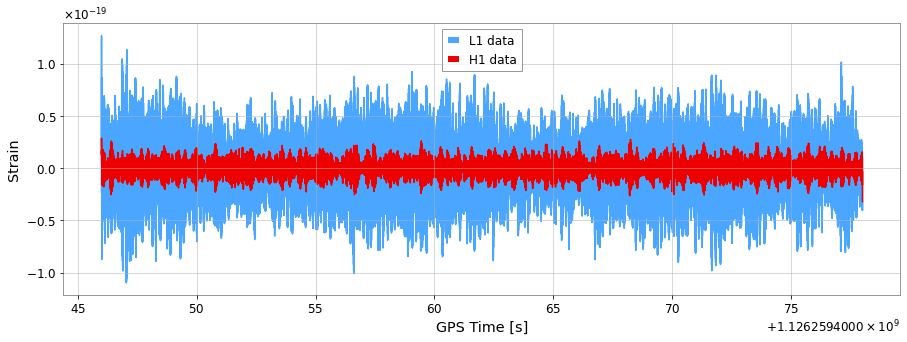

In [ ]:
plt.figure(figsize=(15,5))
colours=['gwpy:ligo-livingston','gwpy:ligo-hanford']

for ifo,colour in zip(ifos,colours):
    plt.plot(data[ifo],label='{} data'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();

## Likelihood

### Noise model

We know the time around **GW150914** to be well-behaved, and by that we mean stationary and Gaussian.  That means we can completely describe the (statistical) properties of the noise by the power spectral density, which we'll estimate using off-source data following the procedure in `chapter5_6.ipynb`.

In [ ]:
psd={}
for ifo in ifos:
    psd[ifo] = data[ifo].psd(fftlength=4)

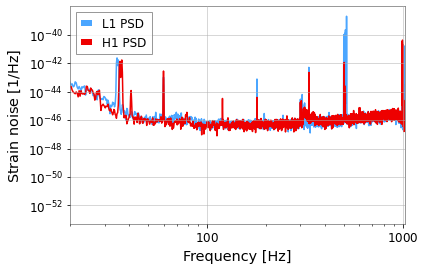

In [ ]:
for ifo,colour in zip(ifos,colours):
    plt.loglog(psd[ifo],label='{} PSD'.format(ifo),color=colour)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain noise [$1/\mathrm{Hz}$]')
plt.xlim(20,1024)
plt.legend();

That's it.  We're going to assume that our noise is exactly described by the PSD estimated above.  In other words, we're employing a 0-parameter noise model.

For production analyses we make use of the [BayesLine](https://arxiv.org/abs/1410.3852) algorithm, which employs a parametric model for the PSD itself and allows us to work with only on-source data.

## Signal model

Here we are using the `SEOBNRv4` approximant, which describes the inspiral, merger, and ringdown phases of a binary black hole merger using a combination of analytical approximations and fits to numerical relativity simulations.

In [ ]:
from pycbc.waveform import get_td_waveform

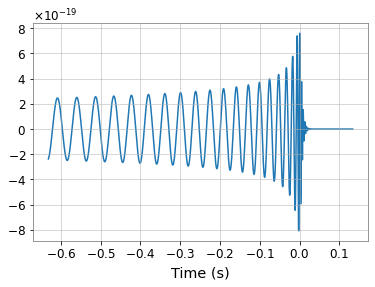

In [ ]:
m1 = 38.9 # Solar masses
m2 = 31.6 # Solar masses

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m1,
                     mass2=m2,
                     delta_t=data['H1'].dt.value,
                     f_lower=20)

plt.plot(hp.sample_times, hp)
plt.xlabel('Time (s)');

With two detectors we are potentially sensitive to more than a single polarization of gravitational waves.  We also have to account for the delay in the time of arrival of the signal based on where in the sky the source may be located.  This expands our parameters to be component mass (assuming an equal mass binary), right ascension, declination, luminosity distance, inclination, merger time, merger phase, and polarization angle.

For a give set of parameters $\vec{\lambda}$ we'll now have to generate the plus and cross polarizations of the GW emission (taking into account the inclination of the binary, and scaling to the proper distance), then combine these with each detector's antenna pattern (which depend on the location of the binary relative to the detector's orientation) to determine the detector response.  Finally, we have to shift the time of arrival of the signal to be consistent with the delay time expected based on the RA and dec of the binary.

In short, you can think of the process as generating the geocenter waveform then projecting it across the network.

Here we will use the `Detector` python object with which we can compute the antenna beam patterns $F_+$ and $F_{\times}$ for a a specific sky-position and polarisation angle:

In [ ]:
from pycbc.detector import Detector

In [ ]:
# Creating the detector objects:
det={}
for ifo in ifos:
    det[ifo]=Detector(ifo)

In [ ]:
declination = 2.2
right_ascension =  -1.2
polarization = 0.0

fp={}
fc={}
for ifo in ifos:
    fp[ifo], fc[ifo] = det[ifo].antenna_pattern(right_ascension, declination, polarization, time_center)
    print("{}: fp={}, fc={}".format(ifo,fp[ifo], fc[ifo]))

L1: fp=0.4241904317962554, fc=0.5200391978797408
H1: fp=-0.15652371090193232, fc=-0.648341400213531


# **Question**
- make a 2D plot (right-ascension and declination) of the $F_+$ (`fp`) and $F_{\times}$ (`fc`) functions for a detector at a fixed polarisation.

With the antenna beam pattern functions we can then compute the gravitational-wave signal as seen by each detector:

In [ ]:
ht={}
for ifo in ifos:
    ht[ifo] = fp[ifo] * hp + fc[ifo] * hc

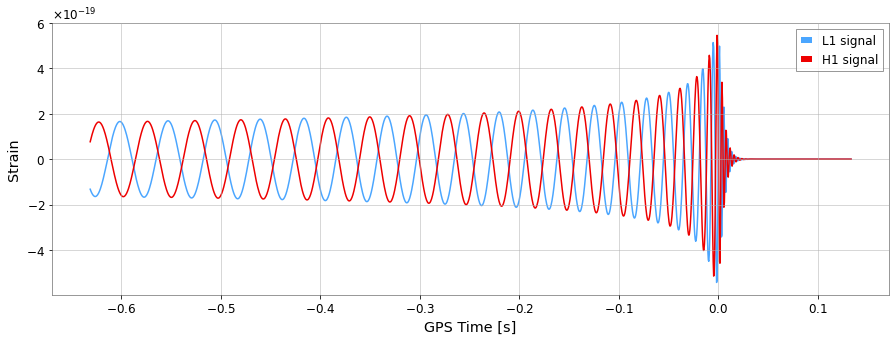

In [ ]:
plt.figure(figsize=(15,5))

for ifo,colour in zip(ifos,colours):
    plt.plot(TimeSeries.from_pycbc(ht[ifo]),label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();

For visualization it is still useful to look at the whitened data, where the data have been filtered to produce a flat PSD. We also remove the frequencies below 30Hz and above 300Hz:

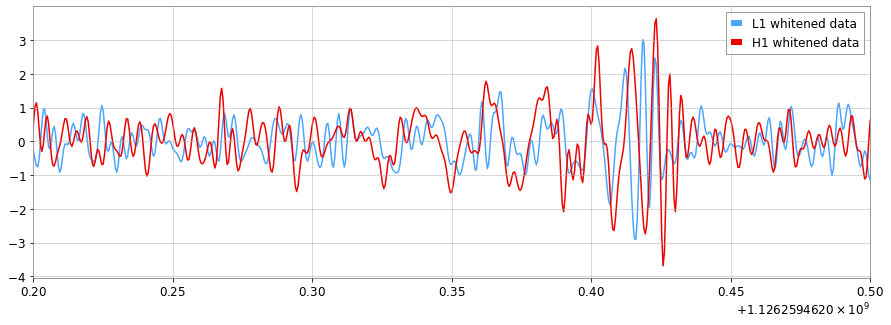

In [ ]:
plt.figure(figsize=(15,5))

white_data={}
for ifo,colour in zip(ifos,colours):
    white_data[ifo]=data[ifo].whiten(fftlength=4).bandpass(30,300)
    plt.plot(white_data[ifo],label='{} whitened data'.format(ifo),color=colour)
plt.xlim(time_center+.2, time_center+.5)
plt.legend();

# **Question**
- the L1 detector is anti-aligned to the H1 detector (by construction). So it is possible to compare both strain data by multiplying one of them by -1. In addition, a time-delay needs to be taken into account to have both whitened data match well. Try to find by eye what that time-delay should be.

We also need to compute the time-delay between our refence time-at-geocenter and the time at which the gravitational-wave signal will hit the detectors:

In [ ]:
time_delay=det['H1'].time_delay_from_earth_center(right_ascension, declination, time_center)

print("For the sky-position ra={},dec={}, at time={},".format(right_ascension,declination,time_center))
print("the time delay between Hanford and geocenter is {} seconds".format(time_delay))

For the sky-position ra=-1.2,dec=2.2, at time=1126259462,
the time delay between Hanford and geocenter is -0.012420895453097505 seconds


# **Question**
- Draw random ra,dec points in the sky, and plot the histogram of the time-delays. Why is it flat?

As in chapter 7, we'll make a light-weight wrapper for `get_td_waveform()` that will take parameter vector $\vec{\lambda}$ and generate a waveform for us with the same sampling rate and time window as our data. However, this time we need to project the "plus" and "cross" polarisations onto the detector arms.

In [ ]:
for ifo in ifos:
    data[ifo]=data[ifo].crop(time_center-2,time_center+2)

In [ ]:
def gen_template(param,
                 delta_t=data['H1'].dt.value, # Assuming all IFOs have the same dt !
                 duration=data['H1'].duration.value, # Assuming all IFOs have the same duration !
                 start_time=data['H1'].x0.value,# Assuming all IFOs have the same start time !
                 f_lower=20.):
    
    m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower) 
    
    # Resize the signal buffer
    hp.resize(int(duration/delta_t))
    hc.resize(int(duration/delta_t))
    
    ht={}
    template={}
    # compute the detectors responses and shift to the requested time
    for ifo in ifos:
        fp, fc = det[ifo].antenna_pattern(right_ascension, declination, polarization, time)
        ht[ifo] = fp * hp.copy() + fc * hc.copy()
        
        time_delay = det[ifo].time_delay_from_earth_center(right_ascension, declination, time)
        
        ht[ifo] = ht[ifo].cyclic_time_shift(ht[ifo].start_time + time - start_time + time_delay)
        ht[ifo].start_time=start_time
    
        template[ifo]=TimeSeries.from_pycbc(ht[ifo])

    return template

(1126259461.9, 1126259462.5)

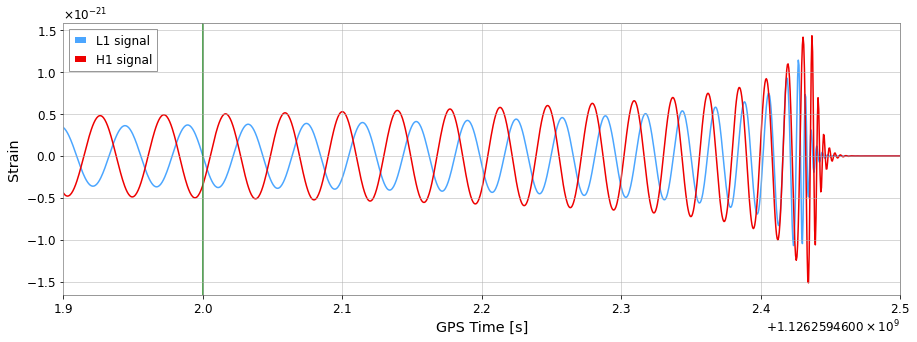

In [ ]:
# Testing the gen_template() function:

param=[38.9,31.6,410,1126259462.42,0.0,2.2, -1.2, 0.1, 0.]
# m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization = param

template=gen_template(param)
plt.figure(figsize=(15,5))

for ifo,colour in zip(ifos,colours):
    plt.plot(template[ifo],label='{} signal'.format(ifo),color=colour)
plt.xlabel('GPS Time [s]')
plt.ylabel('Strain')
plt.legend();
plt.axvline(time_center,c='forestgreen')
plt.xlim([time_center-0.1,time_center+0.5])

With the network waveform generator now defined, we can define our likelihood function, which is equivalent to the product of single-detector likelihood functions.

## Network Likelihood

In chapter 7 we've only worked with one detector, and our inference abilities have been restricted by this.

To construct a likelihood function for the GW detector network (the two LIGO instruments in this case), we will make the very reasonable assumption that noise is independent between detectors.  This means that our network likelihood fuction is just the product of single-detector likelihood functions.

$$
\log \mathcal{L}_\mathrm{net} = \sum_{j \in \{\mathrm{H1}, \mathrm{L1}\}} \log \mathcal{L}_\mathrm{j}
$$



In [ ]:
# FFT the data once, ahead of time
sf={}
for ifo in ifos:
    sf[ifo] = data[ifo].average_fft(window=('tukey',1./4.))*data[ifo].duration.value/2

def loglikelihood(param, sf=sf, f_lower=20.0):

    logl=0.0    
    template = gen_template(param, delta_t=data['H1'].dt.value ,f_lower=f_lower)
    
    for ifo in ifos:
        # zero out the frequencies below f_lower
        sf_hp = sf[ifo].crop(start=f_lower)
        psd_hp = psd[ifo].crop(start=f_lower)
        
        hf = template[ifo].average_fft(window=('tukey',1./4.))*template[ifo].duration.value/2
        hf_hp = hf.crop(start=f_lower)

        h_dot_h  = 4 * np.real((hf_hp * hf_hp.conjugate() / psd_hp).sum() * hf_hp.df)
        h_dot_s  = 4 * np.real((sf_hp * hf_hp.conjugate() / psd_hp).sum() * sf_hp.df)

        logl += h_dot_s - h_dot_h/2

    return logl.value

Now let's pick some particular values for the model parameters that we know to be in the right ballpark and generate a model signal.  We'll then whiten it and compare it to the data, and calculate the likelihood.

-1144.3010436196523


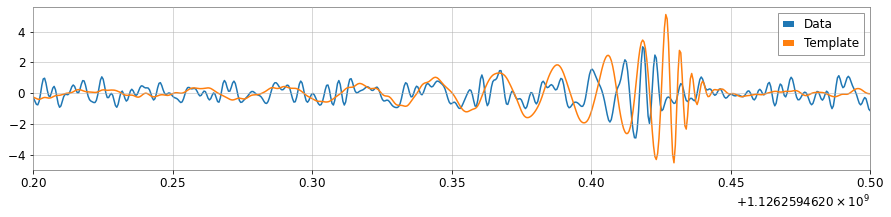

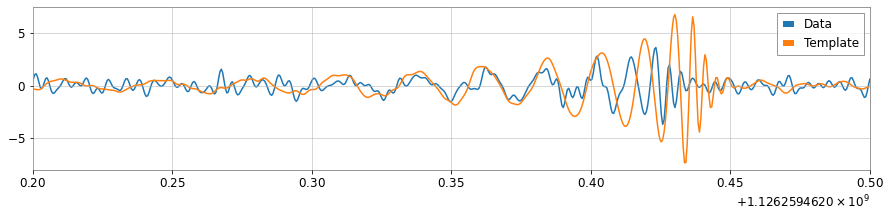

In [ ]:
# m1, m2, distance, time, phase, right_ascension, declination, inclination, polarization
param0 = [38.9,31.6,410,1126259462.42,0.0,2.2, -1.2, 0.1, 0.]

template0 = gen_template(param0)
for ifo in ifos:
    white_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data[ifo].times, white_data[ifo], label="Data")
    plt.plot(white_template.times, white_template, label="Template")

    plt.xlim(time_center+.2, time_center+.5)
    plt.legend();
print(loglikelihood(param0))

Now let's maximize the likelihood to find the best-fit signal.  We'll use the `minimize()` function provided by scipy using the Powell method, since it's pretty good at dealing with non-smooth functions.  We'll also define a callback function to print likelihood values and plot the model as it works.

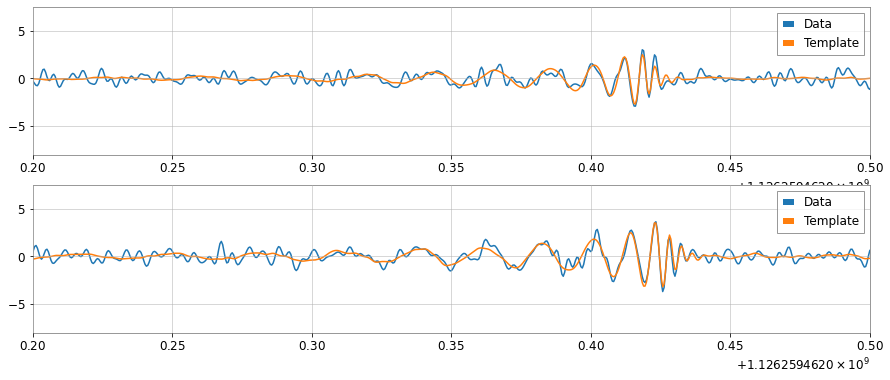

Steps	log(likelihood)
17	352.831


In [ ]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1
    
lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    ax.set_xlim(time_center+.2, time_center+.5)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig
    
    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(param_i)))
    
    Neval += 1
    
res = minimize(lambda param: -loglikelihood(param), param0, callback=callback, method='powell')
plt.close()

We've now got our best-fit waveform, and it matches the data (although the fitting algorith does fail sometimes)

In [ ]:
best_fit = res.x
best_fit_template = gen_template(best_fit)

Now let's subtract it from the data and see how consistent the residuals are with noise. We are using here the [Q-transform](https://en.wikipedia.org/wiki/Constant-Q_transform) to produce a high-resolution time-frequency map of the data:

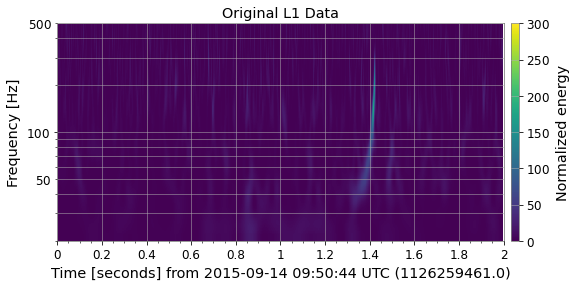

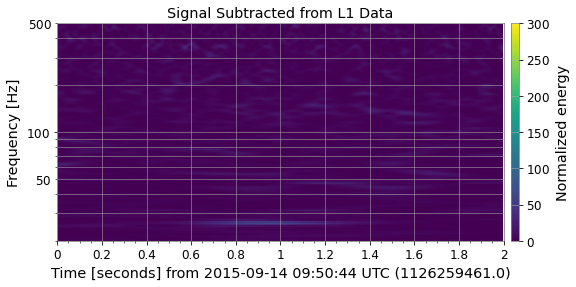

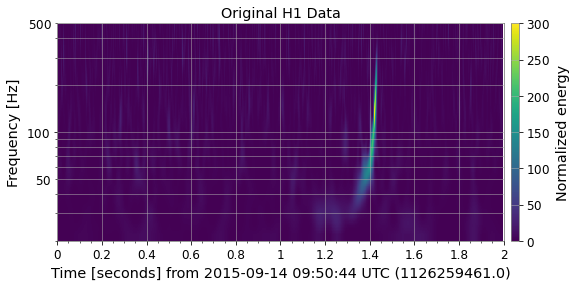

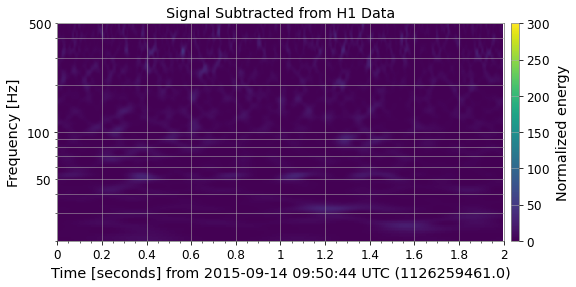

In [ ]:

for i, ifo in enumerate(ifos):
    subtracted = data[ifo] - best_fit_template[ifo]

    # Plot the original data and the subtracted signal data
    for d, title in [(data[ifo], 'Original {} Data'.format(ifo)),
                 (subtracted, 'Signal Subtracted from {} Data'.format(ifo))]:

        qspecgram=d.whiten(asd=np.sqrt(psd[ifo])).q_transform(outseg=(time_center - 1, time_center + 1),
                                                     frange=(20, 512))
        
        plot = qspecgram.plot(figsize=[8, 4],vmin=0,vmax=300)
        ax = plot.gca()
        ax.set_title(title)
        ax.set_xscale('seconds')
        ax.set_yscale('log')
        ax.set_ylim(20, 500)
        ax.set_ylabel('Frequency [Hz]')
        ax.grid(True, axis='y', which='both')
        ax.colorbar(cmap='viridis', label='Normalized energy')

# Prior

So far we've focused on the likelihood, but equally important to Bayesian inference is our prior, the knowledge of the distribution of model parameters that we have *before* taking any measuments.

If we were to sample the likelihood function defined above without specifying any priors, we are implicitly adopting uniform priors for the parameters of the model.  In other words, if we were to sample the same likelihood in a different parameterization, we would implicitly be using a *different* prior for our analysis.

While uniform priors for some parameters (e.g., merger time, merger phase, etc.) are justified, the fact that we expect sources to be distributed uniformly in the local universe (to 1st order) needs to be included in our prior, i.e.,

$$
p(\alpha, \delta) \propto \cos(\delta),
$$

where $\alpha \in [0, 2\pi]$ is the right ascenscion and $\delta \in [-\pi/2, \pi/2]$ the declination of the source, and

$$
p(D, \iota) \propto D^2\sin(\iota)
$$

where $D$ is the luminosity distance to the source, and $\iota$ is the inclination angle of the binary.

In [ ]:
def logprior(param):
    logp = 0
    
    m1, m2, distance, time, phase, ra, dec, inclination, polarization= param
    
    for angle in [ra, phase, polarization]:
        if angle < 0 or angle > 2*np.pi:
            return -np.inf
    if distance < 0:
        return -np.inf
    if inclination < 0 or inclination > np.pi:
        return -np.inf
    if dec < -np.pi/2 or dec > np.pi/2:
        return -np.inf
    
    logp += np.log(np.cos(dec))
    logp += 2*np.log(distance)
    logp += np.log(np.sin(inclination))
    return logp

# Posterior

With network likelihood and prior defined we can now take their product to get the posterior.

In [ ]:
def logposterior(param):
    logpost = logprior(param)
    if np.isfinite(logpost):
        logpost += loglikelihood(param)
    return logpost

In [ ]:
logposterior(param0)

-1135.5881048989656

We can now maximize the posterior to determine the *maximum a posteriori* (MAP) parameters.  

Where the maximum likelihood point was the "best fit" in the sense that it found the parameters that produced a model most consistent with the data, the MAP is more of a "best guess" in that it balances fitting the data with being consistent with prior expectations for source parameters.

However, as the posterior is a density, the MAP **does** depend on the parametrisation we chose.

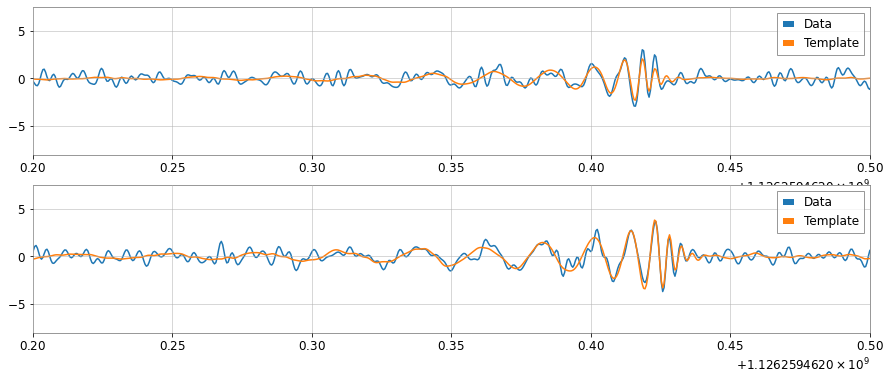

Steps	log(posterior)
26	366.481


In [ ]:
fig, axs = plt.subplots(2, 1, figsize=[15, 6])
Neval = 1
    
lines = {}
for ax, ifo in zip(axs, ifos):
    hite_template = template0[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)

    ax.plot(white_data[ifo].times, white_data[ifo], label="Data")
    lines[ifo], = ax.plot(white_template.times, white_template, label="Template")

    ax.set_xlim(time_center+.2, time_center+.5)
    ax.legend()

def callback(param_i):
    global Neval
    global line
    global fig
    
    template = gen_template(param_i)
    for ifo in ifos:
        white_template = template[ifo].whiten(asd=np.sqrt(psd[ifo]),highpass=20.)
        lines[ifo].set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(posterior)")
    print('{}\t{:.3f}'.format(Neval, logposterior(param_i)))
    
    Neval += 1
    
res = minimize(lambda param: -logposterior(param), param0, callback=callback, method='powell')
plt.close()

In [ ]:
best_guess = res.x
print(best_guess)

[ 4.08180650e+01  3.11861566e+01  7.81355214e+02  1.12625946e+09
  6.14313508e-02  2.54657461e+00 -9.80034807e-01  5.05308137e-01
  2.87978629e-02]


We can easily take a look at some _slices_ in the parameter space, for instance at the `mass1` slice with all other parameters set the `best_guess` parameters:

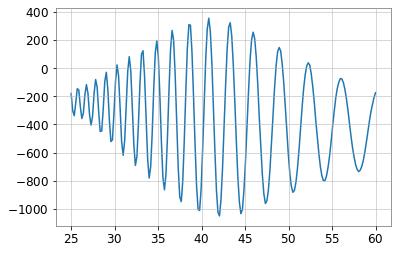

In [ ]:
masses=np.linspace(25,60,num=200)
logl_mass=[]

for mass1 in masses:
    param_test = best_guess
    # m1, m2, distance, time, phase, ra, dec, inclination, polarization = param
    param_test[0] = mass1
    logl_mass.append(loglikelihood(param_test))
    
plt.plot(masses,logl_mass)

**However**, this is just a slice and **not** the marginalised posterior density function for `mass1`. In other to actually compute the marginalised posterior distribution:

$$
p(m_1|s) = \int p(\vec{\lambda}|s)~d (\{\vec{\lambda}\}\setminus \{m_1\})
$$

We need to compute that integral. And one of the most efficient way is to  _sample_ the posterior:

# Posterior sampling

So far we've been generating point estimates for the source parameters, but the whole point of this endeavor was to quantify uncertainties. With our posterior function defined we can now plug into into a Markov chain Monte Carlo sampler in order to draw samples from this probability density function.

With a posterior density function defined, you can now use off-the-shelf samplers, see [Samplers, samplers, everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) to draw samples from the posterior probability density function.